In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
spam = pd.read_csv('../HW6/spam.csv')

# Gaussian Naive Bayes

In [3]:
class ContinuousNaiveBayes():
    def __init__(self):
        self.__features_distribution = []
        self.__classes_freqs = []
        self.__classes_lbls = []
        
    def fit(self, X, y):
        classes, ns = np.unique(y, return_counts=True)
        c_indexes = [y == c for c in classes]
        for c, n in zip(classes, ns):
            self.__features_distribution.append([])
            self.__classes_freqs.append(n / X.shape[0]) 
            
        for j in range(X.shape[1]):
            for c, idx in zip(classes, c_indexes):
                self.__features_distribution[c].append([np.mean(X[idx, j]),
                                                        np.std(X[idx, j]) ** 2])
        
    def predict_proba(self, X):
        probs = np.ones((X.shape[0], 2))
        probs = probs * np.asarray(self.__classes_freqs).reshape(1,2)
        
        for j in range(X.shape[1]):
            p = np.ones((X.shape[0], 2))
            for c in range(2):
                p[:, c] = probs[:, c] * np.exp(- (X[:, j] - self.__features_distribution[c][j][0])  ** 2 \
                                                   / (2 * self.__features_distribution[c][j][1])) \
                   / np.sqrt(2 * np.pi * self.__features_distribution[c][j][1])
                    
            for k in range(X.shape[0]):
                if p[k, 0] == p[k, 1] == 0: # really weird outlier
                    p[k, :] = probs[k, :]
            
            probs = p 
        probs = probs / (probs[:, 0] + probs[:, 1])[:, None] 
        return probs
    
    def eval_model(self, X, y):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        print(f'Accuracy score: {accuracy_score(y, preds)}')
            
        tpr, fpr, _ = roc_curve(y, probs[:, 0])
        print(f'ROC-AUC score: {auc(fpr, tpr)}')
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr)
        plt.title('ROC-кривая')

In [4]:
spam_X_train, spam_X_val, spam_y_train, spam_y_val = train_test_split(spam.drop(columns=['label']).values,
                                                                      spam.label.values,
                                                                      test_size=0.2,
                                                                      shuffle=True,
                                                                      stratify=spam.label.values)

In [5]:
spam_nb = ContinuousNaiveBayes()

In [6]:
spam_nb.fit(spam_X_train, spam_y_train)

Accuracy score: 0.8132464712269273
ROC-AUC score: 0.9453182854942385


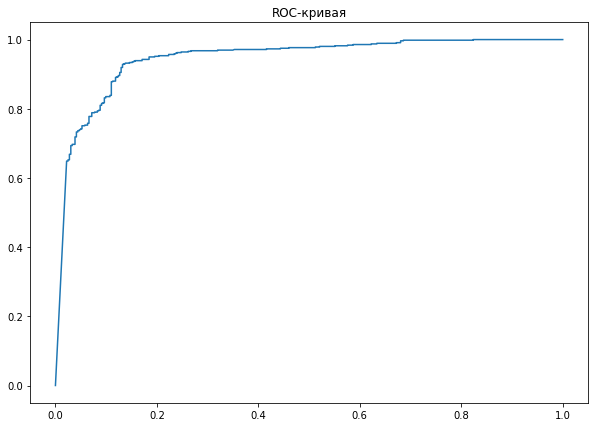

In [7]:
ContinuousNaiveBayes.eval_model(spam_nb, spam_X_val, spam_y_val)

# Multinomial Naive Bayes

In [46]:
smsspam = pd.read_csv('smsspam.csv')
smsspam.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [47]:
smsspam.label = smsspam.label.apply(lambda x: 0 if x == 'ham' else 1)

In [111]:
class TextProcessor():
    def __init__(self):
        self.__words = set()
        self.__stemmer = PorterStemmer()
        self.codes = {}
        
    def fit(self, X):
        for x in X:
            for word in self.__get_document_words(x):
                if word != '':
                    self.__words.add(word)
                    
        lbls, words = pd.factorize(list(self.__words))
        self.codes = dict(zip(words, lbls))
        
    def transform(self, X):
        transformed = np.zeros((X.shape[0], len(self.__words)), dtype=int)
        for i in range(X.shape[0]):
            for w in self.__get_document_words(X[i]):
               
                if w in self.__words:
                    transformed[i][self.codes[w]] += 1
                     
        return transformed
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
        
    def __get_document_words(self, x):
        tokens = word_tokenize(x)
        
        def split_numbers(w):
            res = []
            for d in re.findall('\d+', w):
                res.append(f'$number{len(d)}')
                
            for d in re.findall('[^\d\w]{1}', w):
                res.append(d)
                
            for d in re.split('[\d\W]', w):
                if d != '':
                    res.append(d.lower())
            return res
        
        clean_tokens = []
        for w in tokens:
            for c in split_numbers(w):
                clean_tokens.append(c)
        
        stemmed = list(map(self.__stemmer.stem, 
                        filter(lambda x: x not in stopwords.words('english'), clean_tokens)))
            
        return stemmed

In [48]:
smssp_X_train, smssp_X_val, smssp_y_train, smssp_y_val = train_test_split(smsspam.text.values,
                                                                          smsspam.label.values,
                                                                          test_size=0.2,
                                                                          shuffle=True,
                                                                          stratify=smsspam.label.values)

In [65]:
smsspam_proc = TextProcessor()
smsspam_train_categs = smsspam_proc.fit_transform(smssp_X_train)

In [66]:
smsspam_train_categs.shape

(4457, 5656)

In [67]:
smsspam_val_categs = smsspam_proc.transform(smssp_X_val)

In [102]:
class CategorialNaiveBayes():
    def __init__(self):
        self.__features_counts = None
        self.__classes_freqs = None
        self.__class_sizes = None
        
    def fit(self, X, y):
        classes, ns = np.unique(y, return_counts=True)
        c_indexes = [y == c for c in [0,1]]
        self.__classes_freqs = ns / len(y)
        self.__features_counts = [[[], []] for i in range(X.shape[1])]
        self.__class_sizes = [np.count_nonzero(idx) for idx in c_indexes]
        
        for j in range(X.shape[1]):
            for c, idx in zip(classes, c_indexes):
                counts, ns = np.unique(X[idx, j], return_counts=True)
                max_ = max(counts)
                self.__features_counts[j][c] = [0 for _ in range(max_ + 1)]
                for v, n in zip(counts, ns):
                    self.__features_counts[j][c][v] = n 
                self.__features_counts[j][c] = np.asarray(self.__features_counts[j][c])
                
    def predict_proba(self, X, alpha=0.01):
        probs = np.ones((X.shape[0], 2))
        probs = probs * np.asarray(self.__classes_freqs).reshape(1,2)
        
        for j in range(X.shape[1]):
            for c in range(2):
                l = len(self.__features_counts[j][c])
                K = max(max(X[:, j]), l - 1)
                if K >= l:
                    self.__features_counts[j][c] = np.concatenate((self.__features_counts[j][c],
                                                                   np.zeros(K - l + 1,)), axis=0)
                probs[:, c] = probs[:, c] * (self.__features_counts[j][c][X[:, j]] + alpha) \
                            / (self.__class_sizes[c] + alpha * K) 
     
        probs = probs / (probs[:, 0] + probs[:, 1])[:, None] 
        return probs
    
    def eval_model(self, X, y):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        print(f'Accuracy score: {accuracy_score(y, preds)}')
            
        tpr, fpr, _ = roc_curve(y, probs[:, 0])
        print(f'ROC-AUC score: {auc(fpr, tpr)}')
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr)
        plt.title('ROC-кривая')

In [103]:
nb_sms = CategorialNaiveBayes()

In [104]:
nb_sms.fit(smsspam_train_categs, smssp_y_train)

Accuracy score: 0.9910313901345291
ROC-AUC score: 0.9990551224866953


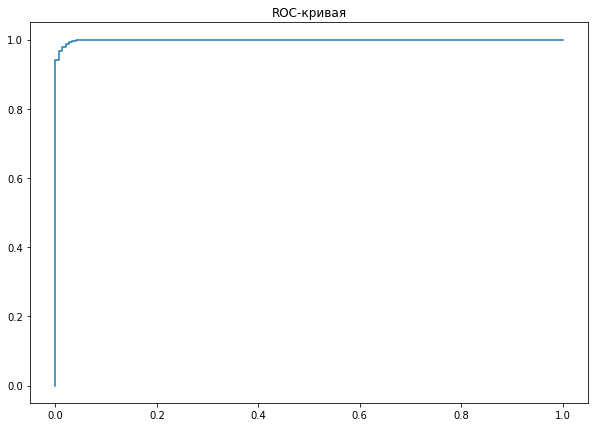

In [106]:
CategorialNaiveBayes.eval_model(nb_sms, smsspam_val_categs, smssp_y_val)